In [1]:
import io
import os

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch import optim
from collections import Counter
import pickle as pkl
import string
import random
import pdb
import nltk
from nltk import ngrams
from collections import Counter
from collections import defaultdict

import copy


import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

import time
import math

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

In [3]:
random.seed(152)

nowPath = os.path.abspath('.')
dataPath = nowPath + '//dataSourceCsv'
resPath = nowPath + '//resultsRNN'
resSeq2Seq = nowPath + '//resultsS2S'

all_train = []
all_val = []

In [4]:
def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [4]:
def showPlot(points, title):
    fig, ax = plt.subplots()
    lines = {}
    lines['cur'], = ax.plot(range(len(points)), points, label='train loss')
    ax.set_title(title)

In [5]:
def pkl_dumper(objct, file_name):
    with open(file_name, 'wb+') as f:
        pkl.dump(objct, f, protocol=None)

def pkl_loader(file_name):
    with open(file_name, 'rb') as f:
        objct = pkl.load(f, encoding = 'bytes')
    return(objct)

In [6]:
def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [7]:
allColNames = pkl_loader(dataPath + '//allColNames.p')
colHeader, colSlot = allColNames['columnHeaders'], allColNames['columnSlots']
allTrainTS = pkl_loader(dataPath + '//allTrainTS.p')
allIDs = pkl_loader(dataPath + '//allIDs.p')
allTgts = pkl_loader(dataPath + '//allTgts.p')

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
newIndex = [i for i, item in enumerate(allTrainTS) if sum(sum(item[:, :9])) != 0.0]
allTgts = np.array(allTgts)
allTrainTS = np.array(allTrainTS)
allTgts = allTgts[newIndex, 3]
allTrainTS = allTrainTS[newIndex]
allIDs = np.array(allIDs)
allIDs = allIDs[newIndex]

In [19]:
## Change all train TSs into pairs

In [11]:
allPairs = [[item[:9, :], item[9:, :]] for item in allTrainTS.transpose(0, 2, 1)]

In [18]:
allPairs, predPairs = allPairs[:int(len(allPairs)*0.8)], allPairs[int(len(allPairs)*0.8):]

In [37]:
predPairs = [[torch.tensor(pair[0], dtype=torch.double, device=device), \
               torch.tensor(pair[1], dtype=torch.double, device=device)] for pair in predPairs]

In [19]:
len(allPairs)

3948

In [20]:
len(predPairs)

987

In [12]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layer):
        super(EncoderRNN, self).__init__()
        self.num_layer = num_layer
        self.hidden_size = hidden_size
        self.linear = nn.Linear(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, num_layer)

    def forward(self, input, hidden):
        # print('InType:', input.type())
        output = self.linear(input).view(1, 1, -1)
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(self.num_layer, 1, self.hidden_size, device=device)

In [13]:
class Attn(nn.Module):
    def __init__(self, hidden_size, method='concat'):
        super(Attn, self).__init__()
        self.method = method
        self.hidden_size = hidden_size
        self.attn = nn.Linear(self.hidden_size * 2, hidden_size)
        self.v = nn.Parameter(torch.rand(hidden_size))
        stdv = 1. / math.sqrt(self.v.size(0))
        self.v.data.normal_(mean=0, std=stdv)

    def forward(self, hidden, encoder_outputs):
        '''
        :param hidden: 
            previous hidden state of the decoder, in shape (layers*directions,B,H)
        :param encoder_outputs:
            encoder outputs from Encoder, in shape (T,B,H)
        :return
            attention energies in shape (B,T)
        '''
        max_len = encoder_outputs.size(0)
        this_batch_size = encoder_outputs.size(1)
        H = hidden.repeat(max_len,1,1).transpose(0,1)
        encoder_outputs = encoder_outputs.transpose(0,1) # [B*T*H]
        attn_energies = self.score(H,encoder_outputs) # compute attention score
        return F.softmax(attn_energies, 2) # normalize with softmax

    def score(self, hidden, encoder_outputs):
        #print('hl size:{}, eo size:{}'.format(hidden.size(), encoder_outputs.size()))
        energy = F.tanh(self.attn(torch.cat([hidden, encoder_outputs.transpose(0,1).unsqueeze(0)], 2))) # [B*T*2H]->[B*T*H]
        energy = energy.transpose(2,1) # [B*H*T]
        v = self.v.repeat(energy.size()[0],1).unsqueeze(0) #[1*B*H]
        #print('v size:{}, eng size:{}'.format(v.size(), energy.size()))
        energy = torch.bmm(v,energy) # [B*1*T]
        #return energy.squeeze(1) #[B*T]
        return energy

In [13]:
class BahdanauAttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_len = 100):
        super(BahdanauAttnDecoderRNN, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_len = max_len
        
        # Define layers
        self.linear = nn.Linear(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        # self.attn = nn.Linear(hidden_size, self.max_len)
        self.attn = Attn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, cur_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        # print('ci size:{}'.format(cur_input.size()))
        vec_input = self.linear(cur_input).view(1, 1, -1) # S=1 x B x N
        vec_input = self.dropout(vec_input)
        # print('vi size:{}, lh size:{}, enc_out size:{}'.format(vec_input.size(), last_hidden.size(), encoder_outputs.size()))
        attn_weights = self.attn(last_hidden[-1], encoder_outputs )
        #print('wt size:{}, eo size:{}'.format(attn_weights.size(), encoder_outputs.size()))
        attn_applied = attn_weights.bmm(encoder_outputs.unsqueeze(0))  # (B,1,V)
        attn_applied = attn_applied.transpose(0, 1)
        #print('we size:{}, lh size:{}, aa size:{}'.format(word_embedded.size(), last_hidden.size(), attn_applied.size()))
        rnn_input = torch.cat((vec_input, attn_applied), 2)
        
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = F.log_softmax(self.out(output))
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [164]:
ee = torch.tensor([1,2,3], dtype = torch.long)

In [165]:
ee

tensor([ 1,  2,  3])

In [166]:
ee.unsqueeze(0).double().type()

'torch.DoubleTensor'

In [14]:
teacher_forcing_ratio = 0.5

def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # print("inLen:{},tgtLen:{}".format(input_length, target_length))

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
    # print('encOutSize:{}'.format(encoder_outputs.size()))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[0.0]*len(colHeader)], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    # use_teacher_forcing = False
    # print(target_tensor.size())

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # print("typeOrg:{}, typeChanged:{}".format(target_tensor[di].type(), target_tensor[di].unsqueeze(0).type()))
            # print("typeDcd:{}".format(decoder_output.type()))
            # print(decoder_output)
            # print(target_tensor[di].unsqueeze(0))
            loss += criterion(decoder_output.double(), target_tensor[di].unsqueeze(0).double())
            decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            # print('forced', decoder_input)

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # topv, topi = decoder_output.topk(1)
            # decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = decoder_output
            # print("typeOrg:{}, typeChanged:{}".format(target_tensor[di].type(), target_tensor[di].unsqueeze(0).type()))
            # print("typeDcd:{}".format(decoder_output.type()))
            # print(decoder_output)
            # print(target_tensor[di].unsqueeze(0))
            loss += criterion(decoder_output.double(), target_tensor[di].unsqueeze(0).double())
            # print('Noforced', decoder_input)
            # print('Noforced_dout', decoder_output)
            

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [46]:
def trainIters(encoder, decoder, n_iters, pairs, n_epoches=1, print_every=1000, plot_every=1000, learning_rate=1e-3, marker='NoSM'):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    trainPairs = copy.deepcopy(pairs)
    random.shuffle(trainPairs)
    # training_pairs = [tensorsFromPair(random.choice(pairs))
    #                   for i in range(n_iters)]
    training_pairs = [[torch.tensor(pair[0], dtype=torch.double, device=device), \
                       torch.tensor(pair[1], dtype=torch.double, device=device)] for pair in trainPairs] * n_epoches
    # criterion = nn.NLLLoss().double()
    criterion = nn.KLDivLoss()
    if n_epoches > 1:
        n_iters = len(training_pairs)

    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    pkl_dumper(plot_losses, resSeq2Seq + '//trainS2S1120'+str(hidden_size)+'_'+str(n_layers)+marker+'.p')
    showPlot(plot_losses)
    

In [220]:
eee = nn.KLDivLoss()

/beegfs/fs1520/pytorch_gpu/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 3s (- 4m 52s) (200 1%) 167.3663
0m 7s (- 4m 43s) (400 2%) 170.6233
0m 11s (- 4m 37s) (600 4%) 158.4046
0m 15s (- 4m 32s) (800 5%) 162.7163
0m 19s (- 4m 28s) (1000 6%) 164.1777
0m 23s (- 4m 24s) (1200 8%) 161.1171
0m 27s (- 4m 20s) (1400 9%) 155.7410
0m 31s (- 4m 15s) (1600 10%) 162.3929
0m 34s (- 4m 11s) (1800 12%) 165.3195
0m 38s (- 4m 7s) (2000 13%) 153.5123
0m 42s (- 4m 3s) (2200 14%) 164.0680
0m 46s (- 4m 0s) (2400 16%) 155.0777
0m 50s (- 3m 56s) (2600 17%) 155.5207
0m 54s (- 3m 52s) (2800 18%) 156.8608
0m 58s (- 3m 48s) (3000 20%) 162.9927
1m 1s (- 3m 44s) (3200 21%) 160.8800
1m 5s (- 3m 40s) (3400 22%) 149.0513
1m 9s (- 3m 36s) (3600 24%) 158.7441
1m 13s (- 3m 32s) (3800 25%) 158.1927
1m 17s (- 3m 28s) (4000 27%) 160.5470
1m 21s (- 3m 24s) (4200 28%) 156.2641
1m 24s (- 3m 20s) (4400 29%) 159.1633
1m 28s (- 3m 17s) (4600 31%) 157.0765
1m 32s (- 3m 13s) (4800 32%) 150.4833
1m 36s (- 3m 9s) (5000 33%) 154.3161
1m 40s (- 3m 5s) (5200 35%) 156.7028
1m 44s (- 3m 1s) (5400 36%) 156.7

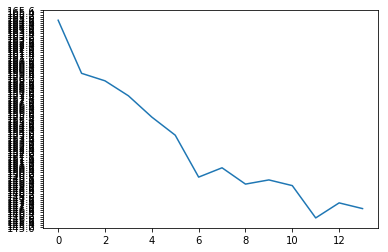

In [235]:
###TrainCuda
hidden_size = 50
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 2
encoder1 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
attn_decoder1 = BahdanauAttnDecoderRNN(hidden_size, out_size, n_layers=n_layers, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 1, allPairs, n_epoches = 3, print_every=200, plot_every = 200, learning_rate=2e-6)

# encoder1.load_state_dict(torch.load("nmt_models/encoder.pth", map_location = 'cpu'))
# attn_decoder1.load_state_dict(torch.load("nmt_models/attn_decoder.pth", map_location = 'cpu'))

In [236]:
torch.save(encoder1.state_dict(), resSeq2Seq + "//encoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+".pth")
torch.save(attn_decoder1.state_dict(), resSeq2Seq + "//attn_decoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+".pth")

/beegfs/fs1520/pytorch_gpu/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 5s (- 6m 16s) (200 1%) 160.2443
0m 10s (- 6m 5s) (400 2%) 162.5962
0m 15s (- 5m 58s) (600 4%) 160.2581
0m 20s (- 5m 52s) (800 5%) 159.0958
0m 25s (- 5m 47s) (1000 6%) 159.7226
0m 30s (- 5m 41s) (1200 8%) 156.7974
0m 35s (- 5m 36s) (1400 9%) 156.3719
0m 40s (- 5m 31s) (1600 10%) 159.9873
0m 45s (- 5m 26s) (1800 12%) 153.5170
0m 50s (- 5m 21s) (2000 13%) 156.9934
0m 55s (- 5m 16s) (2200 14%) 161.4935
1m 0s (- 5m 10s) (2400 16%) 157.1310
1m 5s (- 5m 5s) (2600 17%) 155.9488
1m 10s (- 5m 0s) (2800 18%) 152.9204
1m 15s (- 4m 55s) (3000 20%) 157.1939
1m 20s (- 4m 50s) (3200 21%) 154.9368
1m 25s (- 4m 45s) (3400 22%) 152.9008
1m 30s (- 4m 40s) (3600 24%) 154.6140
1m 35s (- 4m 35s) (3800 25%) 151.2130
1m 40s (- 4m 30s) (4000 27%) 149.3396
1m 45s (- 4m 25s) (4200 28%) 147.9673
1m 50s (- 4m 20s) (4400 29%) 151.2978
1m 55s (- 4m 15s) (4600 31%) 151.9252
2m 0s (- 4m 10s) (4800 32%) 147.1117
2m 5s (- 4m 5s) (5000 33%) 153.3003
2m 10s (- 4m 0s) (5200 35%) 144.5060
2m 15s (- 3m 55s) (5400 36%) 144.

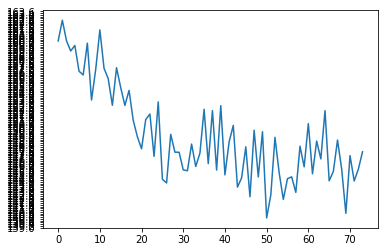

In [233]:
###TrainCuda
hidden_size = 100
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 2
encoder1 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
attn_decoder1 = BahdanauAttnDecoderRNN(hidden_size, out_size, n_layers=n_layers, dropout_p=0.1).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters(encoder1, attn_decoder1, 1, allPairs, n_epoches = 3, print_every=200, plot_every = 200, learning_rate=2e-6)

# encoder1.load_state_dict(torch.load("nmt_models/encoder.pth", map_location = 'cpu'))
# attn_decoder1.load_state_dict(torch.load("nmt_models/attn_decoder.pth", map_location = 'cpu'))

In [234]:
torch.save(encoder1.state_dict(), resSeq2Seq + "//encoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+".pth")
torch.save(attn_decoder1.state_dict(), resSeq2Seq + "//attn_decoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+".pth")

/beegfs/fs1520/pytorch_gpu/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


0m 14s (- 17m 26s) (200 1%) 163.7365
0m 28s (- 17m 4s) (400 2%) 166.4515
0m 42s (- 16m 47s) (600 4%) 161.3159
0m 56s (- 16m 33s) (800 5%) 161.4817
1m 10s (- 16m 18s) (1000 6%) 159.0965
1m 25s (- 16m 3s) (1200 8%) 161.8376
1m 39s (- 15m 49s) (1400 9%) 160.8603
1m 53s (- 15m 34s) (1600 10%) 158.3037
2m 7s (- 15m 20s) (1800 12%) 164.2043
2m 21s (- 15m 5s) (2000 13%) 158.6209
2m 35s (- 14m 51s) (2200 14%) 163.9146
2m 49s (- 14m 37s) (2400 16%) 159.0677
3m 4s (- 14m 24s) (2600 17%) 158.1019
3m 18s (- 14m 9s) (2800 18%) 149.8159
3m 32s (- 13m 55s) (3000 20%) 156.4584
3m 46s (- 13m 41s) (3200 21%) 159.8444
4m 0s (- 13m 27s) (3400 22%) 147.0287
4m 14s (- 13m 12s) (3600 24%) 158.7054
4m 28s (- 12m 58s) (3800 25%) 148.1676
4m 42s (- 12m 44s) (4000 27%) 153.2171
4m 57s (- 12m 30s) (4200 28%) 147.2654
5m 11s (- 12m 16s) (4400 29%) 158.1818
5m 25s (- 12m 1s) (4600 31%) 148.6187
5m 39s (- 11m 47s) (4800 32%) 144.9748
5m 53s (- 11m 33s) (5000 33%) 147.6039
6m 7s (- 11m 19s) (5200 35%) 149.4179
6m 21s

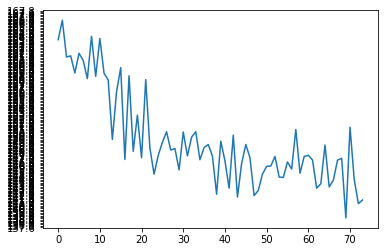

In [237]:
###TrainCuda
hidden_size = 200
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 3
encoder1 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
# attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)
attn_decoder1 = BahdanauAttnDecoderRNN(hidden_size, out_size, n_layers=n_layers, dropout_p=0.1).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters(encoder1, attn_decoder1, 1, allPairs, n_epoches = 3, print_every=200, plot_every = 200, learning_rate=2e-6)

# encoder1.load_state_dict(torch.load("nmt_models/encoder.pth", map_location = 'cpu'))
# attn_decoder1.load_state_dict(torch.load("nmt_models/attn_decoder.pth", map_location = 'cpu'))

In [238]:
torch.save(encoder1.state_dict(), resSeq2Seq + "//encoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+".pth")
torch.save(attn_decoder1.state_dict(), resSeq2Seq + "//attn_decoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+".pth")

In [ ]:
theBestRnnModel.load_state_dict(torch.load(resPath + '/model_400_sub0.00020.model'))

In [16]:
hidden_size = 200
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 3

In [17]:
encoder1 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
attn_decoder1 = BahdanauAttnDecoderRNN(hidden_size, out_size, n_layers=n_layers, dropout_p=0.1).to(device)

In [18]:
encoder1.load_state_dict(torch.load(resSeq2Seq + "//encoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+".pth"))
attn_decoder1.load_state_dict(torch.load(resSeq2Seq + "//attn_decoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+".pth"))

In [42]:
def predictor(input_tensor, target_tensor, encoder, decoder, criterion):
    encoder_hidden = encoder.initHidden()
    
    # print(input_tensor.size)
    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # print(input_length, target_length)

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
    # print('encOutSize:{}'.format(encoder_outputs.size()))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]
        # print(encoder_output[0, 0])

    # decoder_input = torch.tensor([[0.0]*len(colHeader)], device=device)
    decoder_input = input_tensor[input_length-1]

    decoder_hidden = encoder_hidden
    decoder_outputs = torch.zeros(target_length, len(colHeader) , device=device)

    for di in range(target_length):
        decoder_output, decoder_hidden, decoder_attention = decoder(
            decoder_input, decoder_hidden, encoder_outputs)
        decoder_input = decoder_output
        # print(decoder_outputs.size(), decoder_output.size())
        decoder_outputs[di] = decoder_output[0]
        
        loss += criterion(decoder_output.double(), target_tensor[di].unsqueeze(0).double())

    return (decoder_outputs, target_tensor, loss.item() / target_length)

In [23]:
allTgtsObesity = [(i, item) for (i, item) in enumerate(allTgts) if item == 1]

In [27]:
i = 9

In [43]:
predPairs = [[torch.tensor(pair[0], dtype=torch.double, device=device), \
               torch.tensor(pair[1], dtype=torch.double, device=device)] for pair in allPairs]
predicted, target, loss = predictor(predPairs[i][0], predPairs[i][1], encoder1, attn_decoder1, nn.KLDivLoss())

9 6
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])


/beegfs/fs1520/pytorch_gpu/py3.6.3/lib/python3.6/site-packages/ipykernel_launcher.py:39: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [44]:
predicted

tensor([[-2.7202, -2.5493, -3.9636, -3.9467, -4.0362, -3.2221, -2.7002,
         -2.2469, -4.0279, -2.2288, -3.9778, -4.0162, -3.8507, -3.7924,
         -2.5765, -3.9923, -3.2170, -2.4992, -2.5307, -3.9319, -3.9287,
         -3.5740, -4.0415],
        [-2.4226, -2.3883, -4.6738, -4.6500, -4.7801, -3.4033, -2.5944,
         -2.0385, -4.6219, -2.0147, -4.7075, -4.7322, -4.4924, -4.4049,
         -2.3565, -4.7123, -3.3099, -2.3662, -2.3999, -4.6004, -4.6142,
         -4.1142, -4.7696],
        [-2.2115, -2.4753, -5.1318, -5.1735, -5.3437, -3.6006, -2.5446,
         -1.9176, -5.0426, -1.9297, -5.2708, -5.2930, -5.0331, -4.8651,
         -2.1998, -5.2652, -3.4635, -2.3259, -2.4267, -5.1410, -5.1010,
         -4.5371, -5.2629],
        [-2.1269, -2.4582, -5.6912, -5.7762, -5.9455, -3.8054, -2.5124,
         -1.8845, -5.4653, -1.8587, -5.8438, -5.9030, -5.5158, -5.2850,
         -2.1297, -5.8403, -3.6542, -2.2995, -2.3970, -5.6071, -5.6013,
         -4.9909, -5.8375],
        [-2.0767, -2.433

In [45]:
target

tensor([[  70.0000,   50.0000,    0.6531,    0.0000,    0.0000,   16.2700,
            0.0000,   91.4400,    0.0000,   97.0000,    0.0000,    0.0000,
            0.0000,   18.0000,   88.0000,    0.0000,   13.6078,   49.5500,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [  70.0000,   75.0000,    0.6887,    0.0000,    0.0000,   16.5000,
            0.0000,   95.2500,    0.0000,   97.4000,    0.0000,    0.0000,
            0.0000,   16.0000,   78.0000,    0.0000,   14.6662,   61.7500,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [  98.0000,   90.0000,    1.5885,    0.0000,    0.0000,   17.4800,
            0.0000,   97.9932,    0.0000,   98.2000,    0.0000,    0.0000,
            0.0000,   26.0000,  115.0000,    0.0000,   16.7829,   89.6500,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [ 109.0000,   97.5000,    2.4990,    0.0000,    0.0000,   18.8433,
            0.0000,  105.7465,    0.0000,   97.4200,   

### Try No Softmax

In [14]:
class BahdanauAttnDecoderRNN_NoSM(nn.Module):
    def __init__(self, hidden_size, output_size, n_layers=1, dropout_p=0.1, max_len = 100):
        super(BahdanauAttnDecoderRNN_NoSM, self).__init__()
        
        # Define parameters
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout_p
        self.max_len = max_len
        
        # Define layers
        self.linear = nn.Linear(output_size, hidden_size)
        self.dropout = nn.Dropout(dropout_p)
        # self.attn = nn.Linear(hidden_size, self.max_len)
        self.attn = Attn(hidden_size)
        self.gru = nn.GRU(hidden_size * 2, hidden_size, n_layers, dropout=dropout_p)
        self.out = nn.Linear(hidden_size, output_size)
    
    def forward(self, cur_input, last_hidden, encoder_outputs):
        # Note that we will only be running forward for a single decoder time step, but will use all encoder outputs
        
        # Get the embedding of the current input word (last output word)
        # print('ci size:{}'.format(cur_input.size()))
        vec_input = self.linear(cur_input).view(1, 1, -1) # S=1 x B x N
        vec_input = self.dropout(vec_input)
        # print('vi size:{}, lh size:{}, enc_out size:{}'.format(vec_input.size(), last_hidden.size(), encoder_outputs.size()))
        attn_weights = self.attn(last_hidden[-1], encoder_outputs )
        #print('wt size:{}, eo size:{}'.format(attn_weights.size(), encoder_outputs.size()))
        attn_applied = attn_weights.bmm(encoder_outputs.unsqueeze(0))  # (B,1,V)
        attn_applied = attn_applied.transpose(0, 1)
        #print('we size:{}, lh size:{}, aa size:{}'.format(word_embedded.size(), last_hidden.size(), attn_applied.size()))
        rnn_input = torch.cat((vec_input, attn_applied), 2)
        
        output, hidden = self.gru(rnn_input, last_hidden)
        
        # Final output layer
        output = output.squeeze(0) # B x N
        output = self.out(output)
        #print(output.size())
        
        # Return final output, hidden state, and attention weights (for visualization)
        return output, hidden, attn_weights

In [15]:
teacher_forcing_ratio = 0.5

def train_NoSM(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)
    # print("inLen:{},tgtLen:{}".format(input_length, target_length))

    encoder_outputs = torch.zeros(input_length, encoder.hidden_size, device=device)
    # print('encOutSize:{}'.format(encoder_outputs.size()))

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    # decoder_input = torch.tensor([[0.0]*len(colHeader)], device=device)
    decoder_input = input_tensor[input_length-1]

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    # use_teacher_forcing = False
    # print(target_tensor.size())

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # print("typeOrg:{}, typeChanged:{}".format(target_tensor[di].type(), target_tensor[di].unsqueeze(0).type()))
            # print("typeDcd:{}".format(decoder_output.type()))
            # print(decoder_output)
            # print(target_tensor[di].unsqueeze(0))
            loss += criterion(decoder_output.double(), target_tensor[di].unsqueeze(0).double())
            decoder_input = target_tensor[di].unsqueeze(0)  # Teacher forcing
            # print('forced', decoder_input)

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            # topv, topi = decoder_output.topk(1)
            # decoder_input = topi.squeeze().detach()  # detach from history as input
            decoder_input = decoder_output
            # print("typeOrg:{}, typeChanged:{}".format(target_tensor[di].type(), target_tensor[di].unsqueeze(0).type()))
            # print("typeDcd:{}".format(decoder_output.type()))
            # print(decoder_output)
            # print(target_tensor[di].unsqueeze(0))
            loss += criterion(decoder_output.double(), target_tensor[di].unsqueeze(0).double())
            # print('Noforced', decoder_input)
            # print('Noforced_dout', decoder_output)
            

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [46]:
def trainIters_NoSM(encoder, decoder, n_iters, pairs, n_epoches=1, print_every=1000, plot_every=1000, learning_rate=1e-3, \
                    criterion = nn.MSELoss(), marker='NoSM'):
    start = time.time()
    plot_losses = []
    val_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every
    val_loss_total = 0

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    trainPairs = copy.deepcopy(pairs)
    random.shuffle(trainPairs)
    # training_pairs = [tensorsFromPair(random.choice(pairs))
    #                   for i in range(n_iters)]
    training_pairs = [[torch.tensor(pair[0], dtype=torch.double, device=device), \
                       torch.tensor(pair[1], dtype=torch.double, device=device)] for pair in trainPairs] * n_epoches
    # criterion = nn.NLLLoss().double()
    # criterion = nn.KLDivLoss()
    criterion = criterion
    if n_epoches > 1:
        n_iters = len(training_pairs)

    for iter in range(1, n_iters+1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train_NoSM(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            
            this_pred_loss = 0
            for i in range(len(predPairs)):
                _, _, loss3 = predictor(predPairs[i][0], predPairs[i][1], encoder, decoder, nn.MSELoss())
                this_pred_loss += loss3
            this_pred_loss /= print_every
            val_losses.append(this_pred_loss)
            print('%s (%d %d%%) %.4f %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg, this_pred_loss))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0
    pkl_dumper(plot_losses, resSeq2Seq + '//trainS2S1215'+str(hidden_size)+'_'+str(n_layers)+'_'+str(n_epoches)+marker+'.p')
    pkl_dumper(val_losses, resSeq2Seq + '//trainS2S1215_val'+str(hidden_size)+'_'+str(n_layers)+'_'+str(n_epoches)+marker+'.p')
    showPlot(plot_losses, 'train_loss')
    showPlot(val_losses, 'val_loss')
    return(plot_losses, val_losses)
    

In [61]:
###TrainCuda
hidden_size = 200
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 3
encoder2 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
attn_decoder2 = BahdanauAttnDecoderRNN_NoSM(hidden_size, out_size, n_layers=n_layers, dropout_p=0.1).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters_NoSM(encoder2, attn_decoder2, 1, allPairs, n_epoches = 3, print_every=200, plot_every = 200, learning_rate=2e-6)

0m 16s (- 20m 28s) (200 1%) 95.2264
0m 33s (- 20m 7s) (400 2%) 91.7499
0m 50s (- 19m 48s) (600 4%) 94.8018
1m 6s (- 19m 30s) (800 5%) 91.9626
1m 23s (- 19m 13s) (1000 6%) 89.1519
1m 40s (- 18m 58s) (1200 8%) 89.3633
1m 57s (- 18m 42s) (1400 9%) 91.1984
2m 13s (- 18m 25s) (1600 10%) 88.5093
2m 30s (- 18m 8s) (1800 12%) 82.2186
2m 47s (- 17m 52s) (2000 13%) 82.6931
3m 4s (- 17m 35s) (2200 14%) 76.8564
3m 21s (- 17m 19s) (2400 16%) 81.1611
3m 37s (- 17m 2s) (2600 17%) 79.5382
3m 54s (- 16m 45s) (2800 18%) 72.8502
4m 11s (- 16m 28s) (3000 20%) 69.0142
4m 27s (- 16m 11s) (3200 21%) 62.6276
4m 44s (- 15m 54s) (3400 22%) 54.4415
5m 1s (- 15m 38s) (3600 24%) 46.8976
5m 18s (- 15m 21s) (3800 25%) 36.2465
5m 34s (- 15m 4s) (4000 27%) 23.7884
5m 51s (- 14m 48s) (4200 28%) 12.1856
6m 8s (- 14m 31s) (4400 29%) -1.9402
6m 25s (- 14m 14s) (4600 31%) -18.8181
6m 41s (- 13m 57s) (4800 32%) -36.2828
6m 58s (- 13m 40s) (5000 33%) -51.0773
7m 15s (- 13m 24s) (5200 35%) -70.2523
7m 32s (- 13m 7s) (5400 36%

RuntimeError: Locator attempting to generate 7705 ticks from -1375.4 to 165.4: exceeds Locator.MAXTICKS

RuntimeError: Locator attempting to generate 7705 ticks from -1375.4 to 165.4: exceeds Locator.MAXTICKS

1m 1s (- 39m 10s) (500 2%) 1640.1367 1570.8803
1m 48s (- 34m 1s) (1000 5%) 686.7603 1231.0002
2m 36s (- 31m 39s) (1500 7%) 1880.1436 1229.6963
3m 29s (- 30m 58s) (2000 10%) 635.0884 1377.6869
4m 19s (- 29m 46s) (2500 12%) 513.8594 1279.1073
5m 7s (- 28m 34s) (3000 15%) 884.5451 1297.4507
5m 54s (- 27m 25s) (3500 17%) 562.3222 1303.7399
6m 45s (- 26m 36s) (4000 20%) 924.9472 1310.6420
7m 36s (- 25m 45s) (4500 22%) 684.4157 1308.6841
8m 23s (- 24m 45s) (5000 25%) 473.9476 1297.4982
9m 17s (- 24m 3s) (5500 27%) 1796.8052 1299.7667
10m 4s (- 23m 5s) (6000 30%) 564.1545 1292.7342
10m 53s (- 22m 11s) (6500 32%) 458.6340 1278.3426
11m 38s (- 21m 11s) (7000 35%) 832.1192 1310.1568
12m 24s (- 20m 15s) (7500 37%) 923.8876 1297.3819
13m 17s (- 19m 30s) (8000 40%) 478.6539 1274.3576
14m 7s (- 18m 40s) (8500 43%) 641.0372 1275.5275
14m 52s (- 17m 45s) (9000 45%) 434.3866 1251.4800
15m 44s (- 16m 57s) (9500 48%) 1772.4160 1332.5181
16m 35s (- 16m 9s) (10000 50%) 553.6394 1356.2624
17m 31s (- 15m 25s

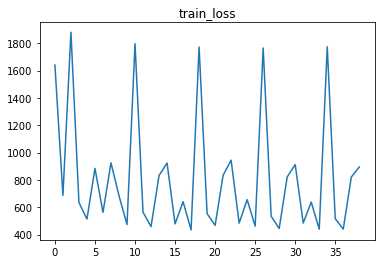

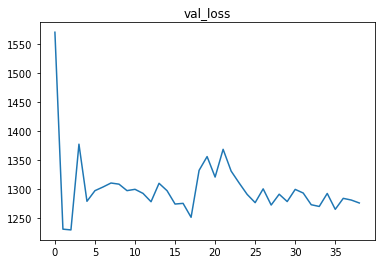

In [48]:
###TrainCuda
hidden_size = 185
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 2
encoder88 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
attn_decoder88 = BahdanauAttnDecoderRNN_NoSM(hidden_size, out_size, n_layers=n_layers, dropout_p=0.4).to(device)

train88, val88 = trainIters_NoSM(encoder88, attn_decoder88, 1, allPairs, n_epoches = 5, print_every=500, plot_every = 500, learning_rate=2e-6)

0m 37s (- 24m 9s) (500 2%) 95.2291 3230.6463
1m 15s (- 23m 28s) (1000 5%) 90.4984 3211.5997
1m 50s (- 22m 28s) (1500 7%) 81.5139 3176.8638
2m 26s (- 21m 41s) (2000 10%) 64.8759 3116.5687
3m 3s (- 21m 3s) (2500 12%) 45.0172 3026.9352
3m 38s (- 20m 21s) (3000 15%) 15.1201 2914.7897
4m 14s (- 19m 43s) (3500 17%) -22.9711 2787.7301
4m 51s (- 19m 5s) (4000 20%) -65.2439 2651.9420
5m 28s (- 18m 33s) (4500 22%) -114.6205 2508.9847
6m 28s (- 19m 6s) (5000 25%) -165.8432 2364.2318
7m 24s (- 19m 11s) (5500 27%) -225.2188 2220.8796
8m 15s (- 18m 54s) (6000 30%) -269.0916 2088.6644
9m 9s (- 18m 39s) (6500 32%) -341.0175 1957.9429
10m 1s (- 18m 14s) (7000 35%) -402.6246 1836.4916
10m 58s (- 17m 55s) (7500 37%) -462.7829 1725.4852
11m 52s (- 17m 25s) (8000 40%) -523.8147 1625.8049
12m 46s (- 16m 53s) (8500 43%) -593.1012 1536.1518
13m 38s (- 16m 16s) (9000 45%) -645.3379 1459.0194
14m 39s (- 15m 48s) (9500 48%) -718.5715 1392.6897
15m 34s (- 15m 10s) (10000 50%) -745.6567 1340.5289
16m 26s (- 14m 28

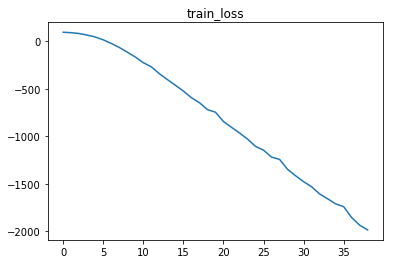

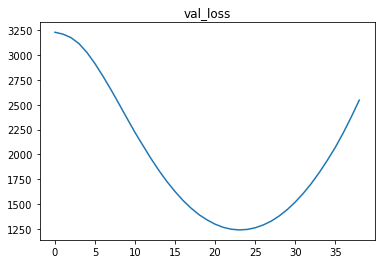

In [49]:
###TrainCuda
hidden_size = 180
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 2
encoder89 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
attn_decoder89 = BahdanauAttnDecoderRNN_NoSM(hidden_size, out_size, n_layers=n_layers, dropout_p=0.4).to(device)

train89, val89 = trainIters_NoSM(encoder89, attn_decoder89, 1, allPairs, n_epoches = 5, print_every=500, plot_every = 500, learning_rate=2e-6, criterion = nn.KLDivLoss())

0m 50s (- 32m 29s) (500 2%) 1880.4360 3206.7760
1m 40s (- 31m 31s) (1000 5%) 1857.1912 3099.1411
2m 31s (- 30m 37s) (1500 7%) 3499.3795 2890.7125
3m 20s (- 29m 36s) (2000 10%) 1655.6248 2650.7977
4m 11s (- 28m 51s) (2500 12%) 1523.9475 2416.3014
5m 1s (- 28m 2s) (3000 15%) 1397.6788 2201.4072
5m 52s (- 27m 15s) (3500 17%) 1744.3579 2007.7687
6m 42s (- 26m 25s) (4000 20%) 1293.3517 1847.9588
7m 35s (- 25m 42s) (4500 22%) 1034.6856 1717.0276
8m 27s (- 24m 55s) (5000 25%) 937.2575 1609.5859
9m 18s (- 24m 5s) (5500 27%) 2587.8242 1521.1716
10m 6s (- 23m 8s) (6000 30%) 833.0964 1450.2070
10m 55s (- 22m 15s) (6500 32%) 810.9375 1396.6887
11m 40s (- 21m 15s) (7000 35%) 786.0181 1353.9304
12m 25s (- 20m 15s) (7500 37%) 1203.6857 1318.6732
13m 10s (- 19m 19s) (8000 40%) 867.4991 1292.7393
13m 54s (- 18m 23s) (8500 43%) 661.0139 1273.3456
14m 39s (- 17m 29s) (9000 45%) 633.1765 1257.8874
15m 23s (- 16m 35s) (9500 48%) 2327.7971 1246.6668
16m 7s (- 15m 42s) (10000 50%) 614.7245 1237.8702
16m 52s 

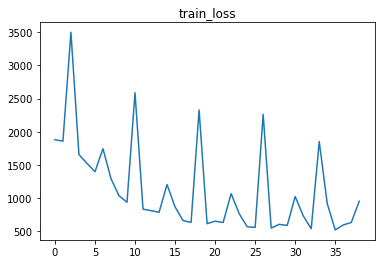

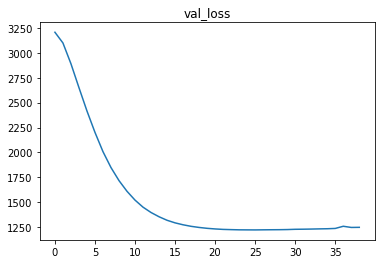

In [50]:
###TrainCuda
hidden_size = 185
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 2
encoder90 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
attn_decoder90 = BahdanauAttnDecoderRNN_NoSM(hidden_size, out_size, n_layers=n_layers, dropout_p=0.4).to(device)

train90, val90 = trainIters_NoSM(encoder90, attn_decoder90, 1, allPairs, n_epoches = 5, print_every=500, plot_every = 500, learning_rate=2e-6)

In [62]:
torch.save(encoder1.state_dict(), resSeq2Seq + "//encoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+'NoSM'+".pth")
torch.save(attn_decoder1.state_dict(), resSeq2Seq + "//attn_decoder_test1120_"+str(hidden_size)+"_"+str(n_layers)+'NoSM'+".pth")

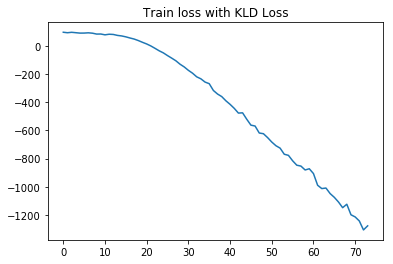

In [78]:
trainPltNoSM = pkl_loader(resSeq2Seq+'//trainS2S1120200_3NoSM.p')
showPlot(trainPltNoSM, 'Train loss with KLD Loss')

In [63]:
i=9
predPairs = [[torch.tensor(pair[0], dtype=torch.double, device=device), \
               torch.tensor(pair[1], dtype=torch.double, device=device)] for pair in allPairs]
predicted, target, loss = predictor(predPairs[i][0], predPairs[i][1], encoder2, attn_decoder2, nn.KLDivLoss())

9 6
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])


In [64]:
predicted

tensor([[ 52.0003,  52.6809,   0.6909,   0.7177,  -0.1692,  14.8363,
          40.6231,  84.6083,  -0.5119,  86.7177,   0.5263,   0.2546,
           1.4771,   3.4274,  56.7788,  -0.1753,  14.8764,  56.2412,
          47.8275,   0.8216,  -0.3619,   5.6314,  -0.4138],
        [ 55.0163,  55.7179,   0.7341,   0.7595,  -0.1831,  15.6769,
          42.9664,  89.5123,  -0.5449,  91.7331,   0.5708,   0.2603,
           1.5624,   3.6418,  60.0666,  -0.1780,  15.7387,  59.4919,
          50.6120,   0.8567,  -0.3710,   5.9429,  -0.4453],
        [ 55.6449,  56.3622,   0.7490,   0.7677,  -0.1850,  15.8599,
          43.4581,  90.5479,  -0.5515,  92.7998,   0.5719,   0.2711,
           1.5795,   3.6845,  60.7573,  -0.1728,  15.9224,  60.1755,
          51.1951,   0.8703,  -0.3684,   6.0148,  -0.4499],
        [ 55.7937,  56.5190,   0.7540,   0.7676,  -0.1858,  15.9054,
          43.5739,  90.7982,  -0.5522,  93.0580,   0.5692,   0.2760,
           1.5841,   3.6928,  60.9218,  -0.1709,  15.9672,  6

In [65]:
target

tensor([[  70.0000,   50.0000,    0.6531,    0.0000,    0.0000,   16.2700,
            0.0000,   91.4400,    0.0000,   97.0000,    0.0000,    0.0000,
            0.0000,   18.0000,   88.0000,    0.0000,   13.6078,   49.5500,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [  70.0000,   75.0000,    0.6887,    0.0000,    0.0000,   16.5000,
            0.0000,   95.2500,    0.0000,   97.4000,    0.0000,    0.0000,
            0.0000,   16.0000,   78.0000,    0.0000,   14.6662,   61.7500,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [  98.0000,   90.0000,    1.5885,    0.0000,    0.0000,   17.4800,
            0.0000,   97.9932,    0.0000,   98.2000,    0.0000,    0.0000,
            0.0000,   26.0000,  115.0000,    0.0000,   16.7829,   89.6500,
            0.0000,    0.0000,    0.0000,    0.0000,    0.0000],
        [ 109.0000,   97.5000,    2.4990,    0.0000,    0.0000,   18.8433,
            0.0000,  105.7465,    0.0000,   97.4200,   

In [68]:
###TrainCuda
hidden_size = 200
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 3
encoder3 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
attn_decoder3 = BahdanauAttnDecoderRNN_NoSM(hidden_size, out_size, n_layers=n_layers, dropout_p=0.1).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters_NoSM(encoder2, attn_decoder2, 1, allPairs, n_epoches = 3, print_every=200, plot_every = 200, \
                criterion = nn.MSELoss(), learning_rate=2e-6, marker = 'MSE')

0m 15s (- 18m 57s) (200 1%) 1530.0017
0m 31s (- 18m 37s) (400 2%) 650.0027
0m 46s (- 18m 20s) (600 4%) 669.5119
1m 1s (- 18m 4s) (800 5%) 664.5804
1m 17s (- 17m 48s) (1000 6%) 605.6238
1m 32s (- 17m 33s) (1200 8%) 596.6952
1m 48s (- 17m 17s) (1400 9%) 588.5593
2m 3s (- 17m 2s) (1600 10%) 3867.8733
2m 19s (- 16m 46s) (1800 12%) 599.6359
2m 34s (- 16m 30s) (2000 13%) 591.1577
2m 50s (- 16m 14s) (2200 14%) 582.2102
3m 5s (- 15m 59s) (2400 16%) 605.4794
3m 21s (- 15m 43s) (2600 17%) 600.6460
3m 36s (- 15m 28s) (2800 18%) 999.9477
3m 52s (- 15m 13s) (3000 20%) 581.4780
4m 7s (- 14m 57s) (3200 21%) 566.7406
4m 23s (- 14m 42s) (3400 22%) 572.1035
4m 38s (- 14m 27s) (3600 24%) 561.8290
4m 54s (- 14m 11s) (3800 25%) 576.1914
5m 9s (- 13m 56s) (4000 27%) 1559.3339
5m 25s (- 13m 40s) (4200 28%) 705.7698
5m 40s (- 13m 25s) (4400 29%) 594.7343
5m 56s (- 13m 9s) (4600 31%) 715.9430
6m 11s (- 12m 54s) (4800 32%) 598.1907
6m 27s (- 12m 38s) (5000 33%) 529.1394
6m 42s (- 12m 23s) (5200 35%) 1474.3704
6

RuntimeError: Locator attempting to generate 18486 ticks from 339.0 to 4036.0: exceeds Locator.MAXTICKS

RuntimeError: Locator attempting to generate 18486 ticks from 339.0 to 4036.0: exceeds Locator.MAXTICKS

In [ ]:
trainPltNoSMMSE = pkl_loader(resSeq2Seq+'//trainS2S1120200_3MSE.p')

Text(0.5,1,'title')

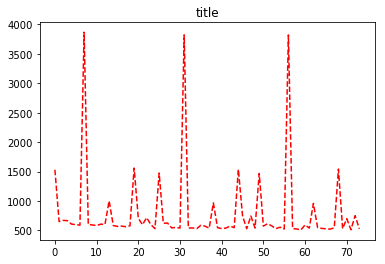

In [102]:
fig, ax = plt.subplots()
lines = {}
lines['cur'], = ax.plot(range(len(trainPltNoSMMSE)), trainPltNoSMMSE, '--', color='red', label='train loss')
ax.set_title('title')

In [80]:
i=9
predPairs = [[torch.tensor(pair[0], dtype=torch.double, device=device), \
               torch.tensor(pair[1], dtype=torch.double, device=device)] for pair in allPairs]
predicted3, target3, loss3 = predictor(predPairs[i][0], predPairs[i][1], encoder3, attn_decoder3, nn.KLDivLoss())

9 6
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])
torch.Size([6, 23]) torch.Size([1, 23])


In [86]:
print('colHeaders:{}'.format([item for item in enumerate(colHeader)]))

colHeaders:[(0, 'Vital: BP'), (1, 'Vital: Wt for Len Percentile'), (2, 'Vital: Wt for Length ZScore'), (3, 'Vital: PEF'), (4, 'Vital: PainScale'), (5, 'Vital: BMI'), (6, 'Vital: Ht Percentile'), (7, 'Vital: Ht'), (8, 'Vital: HC Percentile'), (9, 'Vital: Temp'), (10, 'Vital: SpO2'), (11, 'Vital: Vision'), (12, 'Vital: Wt Change'), (13, 'Vital: RR'), (14, 'Vital: HR'), (15, 'Vital: PL'), (16, 'Vital: Wt'), (17, 'Vital: BMI Percentile'), (18, 'Vital: Wt Percentile'), (19, 'Vital: Hearing'), (20, 'Vital: Pre-gravid Wt'), (21, 'Vital: HC'), (22, 'Vital: Fundal Ht')]


In [87]:
print('7, 9, 16')

7, 9, 16


In [92]:
predicted[:, 7]

array([ 84.60826142,  89.51226273,  90.54785871,  90.79822961,
        90.87817504,  90.89835749])

In [90]:
predicted = np.array(predicted.detach().numpy())
target = np.array(target.detach().numpy())

In [134]:
def plotter(c1, c1pred, c2, c2pred, c3, c3pred, ind, title, label, lim):
    listXlabel = colSlot[-6:]
    c1 = np.array(c1.detach().numpy())[:,ind]
    c2 = np.array(c2.detach().numpy())[:,ind]
    c3 = np.array(c3.detach().numpy())[:,ind]
    c1pred = np.array(c1pred.detach().numpy())[:,ind]
    c2pred = np.array(c2pred.detach().numpy())[:,ind]
    c3pred = np.array(c3pred.detach().numpy())[:,ind]
    fig, ax = plt.subplots(figsize=(12, 8))
    lines = {}
    lines['c1'], = ax.plot(listXlabel, c1, '-', label='c1_true, obesity', color = 'red')
    lines['c1pred'], = ax.plot(listXlabel, c1pred, '--', label='c1_pred, obesity', color = 'red')
    lines['c2'], = ax.plot(listXlabel, c2, '-', label='c2_true, non-obesity', color = 'blue')
    lines['c2pred'], = ax.plot(listXlabel, c2pred, '--', label='c2_pred, non-obesity', color = 'blue')
    lines['c3'], = ax.plot(listXlabel, c3, '-', label='c3_true, non-obesity', color = 'green')
    lines['c3pred'], = ax.plot(listXlabel, c3pred, '--', label='c3_pred, non-obesity', color = 'green')
    legend = ax.legend(loc='lower right', shadow=True)
    ax.set_ylabel(label)
    # ax.set_xlabel(listXlabel)
    ax.set_title(title)
    plt.ylim(lim[0], lim[1])

In [ ]:
plotter(c1, c1pred, c2, c2pred, c3, c3pred, ind, title, label, lim)

In [127]:
preds = [0]*3
tgts = [0]*3
listChild = [9, 16, 512]
for j, i in enumerate(listChild):
    preds[j], tgts[j], loss = predictor(predPairs[i][0], predPairs[i][1], encoder2, attn_decoder2, nn.KLDivLoss())

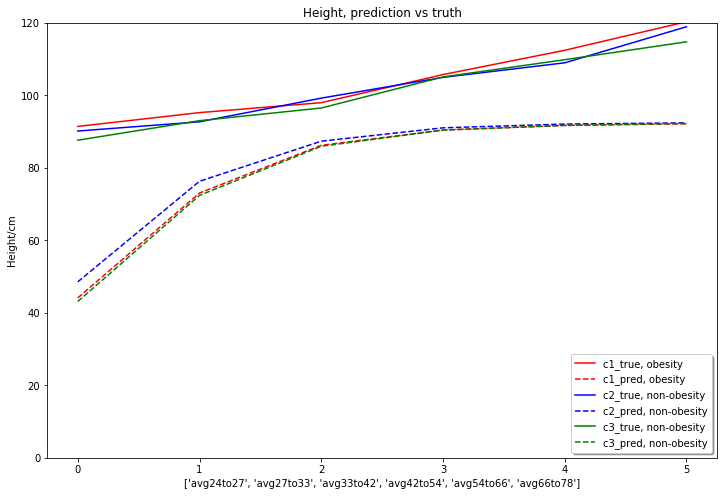

In [128]:
plotter(tgts[0], preds[0], tgts[1], preds[1], tgts[2], preds[2], 7, 'Height, prediction vs truth', 'Height/cm', [0, 120])

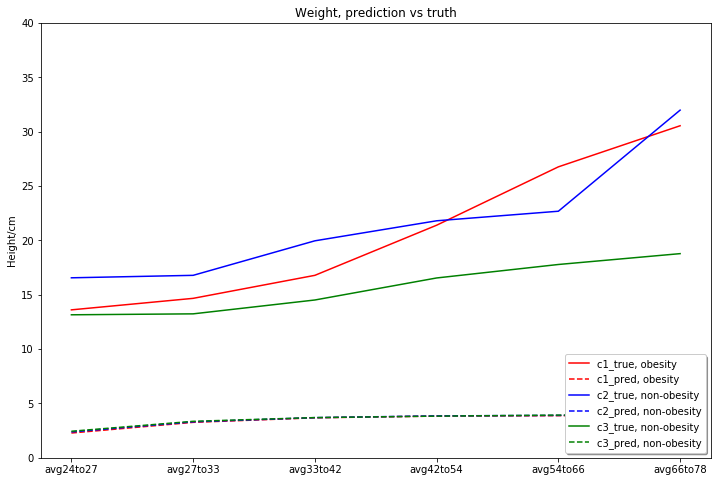

In [152]:
plotter(tgts[0], preds[0], tgts[1], preds[1], tgts[2], preds[2], 16, 'Weight, prediction vs truth', 'Height/cm', [0, 40])

### Try another decoder input

In [136]:
###TrainCuda
hidden_size = 200
in_size = len(colHeader)
out_size = len(colHeader)
n_layers = 3
encoder55 = EncoderRNN(in_size, hidden_size, n_layers).to(device)
attn_decoder55 = BahdanauAttnDecoderRNN_NoSM(hidden_size, out_size, n_layers=n_layers, dropout_p=0.1).to(device)

##UNCOMMENT TO TRAIN THE MODEL
trainIters_NoSM(encoder55, attn_decoder55, 1, allPairs, n_epoches = 2, print_every=200, plot_every = 200, \
                criterion = nn.KLDivLoss(), learning_rate=2e-6, marker = 'KLDivLossAnotherDecIn')

0m 14s (- 11m 39s) (200 2%) -325.0312
0m 28s (- 11m 25s) (400 4%) -346.8031
0m 43s (- 11m 9s) (600 6%) -370.0437
0m 57s (- 10m 54s) (800 8%) -390.6389
1m 12s (- 10m 39s) (1000 10%) -420.5664
1m 26s (- 10m 24s) (1200 12%) -459.2873
1m 40s (- 10m 9s) (1400 14%) -473.0793
1m 55s (- 9m 55s) (1600 16%) -507.1899
2m 9s (- 9m 40s) (1800 18%) -545.6167
2m 24s (- 9m 26s) (2000 20%) -565.7817
2m 38s (- 9m 12s) (2200 22%) -594.6960
2m 52s (- 8m 57s) (2400 24%) -633.4773
3m 7s (- 8m 43s) (2600 26%) -631.5766
3m 21s (- 8m 28s) (2800 28%) -683.2442
3m 35s (- 8m 14s) (3000 30%) -689.8159
3m 50s (- 7m 59s) (3200 32%) -726.6715
4m 4s (- 7m 45s) (3400 34%) -734.0242
4m 19s (- 7m 31s) (3600 36%) -775.9469
4m 33s (- 7m 16s) (3800 38%) -769.6584
4m 47s (- 7m 2s) (4000 40%) -835.3935
5m 2s (- 6m 48s) (4200 42%) -866.8361
5m 16s (- 6m 33s) (4400 44%) -846.1589
5m 30s (- 6m 19s) (4600 46%) -902.5211
5m 45s (- 6m 4s) (4800 48%) -929.2996
5m 59s (- 5m 50s) (5000 50%) -962.9097
6m 13s (- 5m 35s) (5200 52%) -960.

TypeError: showPlot() missing 1 required positional argument: 'title'

In [137]:
torch.save(encoder55.state_dict(), resSeq2Seq + "//encoder_test1121_"+str(hidden_size)+"_"+str(n_layers)+'NoSM_another'+".pth")
torch.save(attn_decoder55.state_dict(), resSeq2Seq + "//attn_decoder_test1121_"+str(hidden_size)+"_"+str(n_layers)+'NoSM_another'+".pth")

In [139]:
preds3 = [0]*3
tgts3 = [0]*3
listChild = [9, 16, 512]
for j, i in enumerate(listChild):
    preds3[j], tgts3[j], loss = predictor(predPairs[i][0], predPairs[i][1], encoder55, attn_decoder55, nn.KLDivLoss())

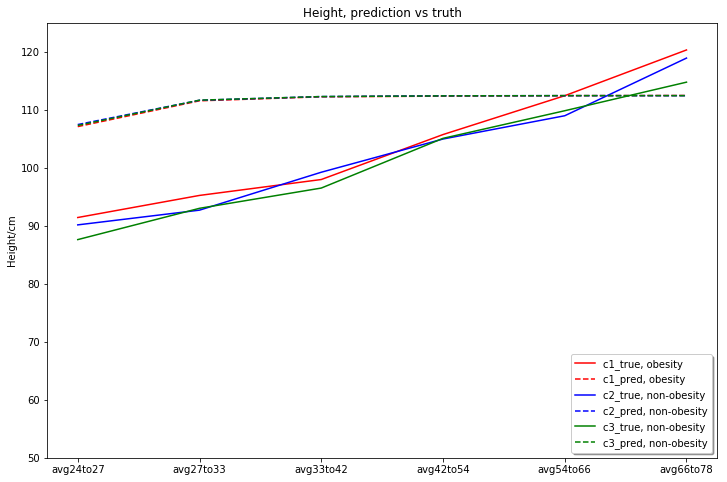

In [142]:
plotter(tgts3[0], preds3[0], tgts3[1], preds3[1], tgts3[2], preds3[2], 7, 'Height, prediction vs truth', 'Height/cm', [50, 125])

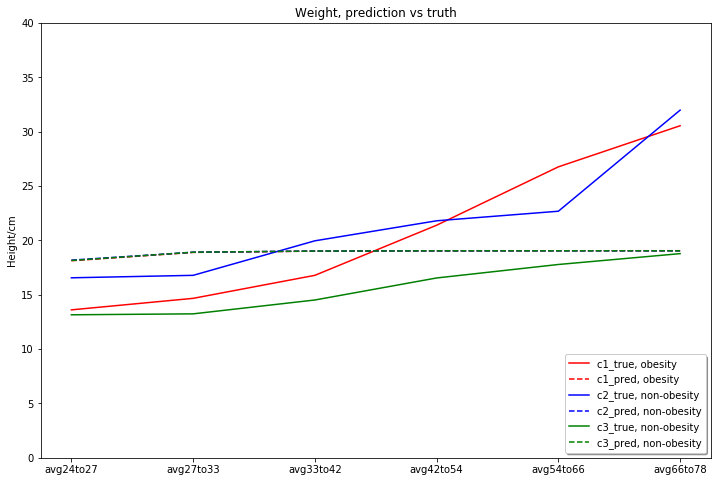

In [151]:
plotter(tgts3[0], preds3[0], tgts3[1], preds3[1], tgts3[2], preds3[2], 16, 'Weight, prediction vs truth', 'Height/cm', [0, 40])

In [106]:
allTgtsObesity

[(9, 1.0),
 (10, 1.0),
 (14, 1.0),
 (16, 1.0),
 (17, 1.0),
 (19, 1.0),
 (23, 1.0),
 (24, 1.0),
 (25, 1.0),
 (28, 1.0),
 (32, 1.0),
 (34, 1.0),
 (39, 1.0),
 (44, 1.0),
 (47, 1.0),
 (51, 1.0),
 (58, 1.0),
 (59, 1.0),
 (61, 1.0),
 (64, 1.0),
 (78, 1.0),
 (80, 1.0),
 (81, 1.0),
 (85, 1.0),
 (86, 1.0),
 (88, 1.0),
 (90, 1.0),
 (93, 1.0),
 (106, 1.0),
 (115, 1.0),
 (116, 1.0),
 (117, 1.0),
 (118, 1.0),
 (127, 1.0),
 (128, 1.0),
 (132, 1.0),
 (138, 1.0),
 (145, 1.0),
 (148, 1.0),
 (152, 1.0),
 (153, 1.0),
 (156, 1.0),
 (161, 1.0),
 (167, 1.0),
 (170, 1.0),
 (180, 1.0),
 (189, 1.0),
 (191, 1.0),
 (197, 1.0),
 (212, 1.0),
 (216, 1.0),
 (221, 1.0),
 (226, 1.0),
 (230, 1.0),
 (231, 1.0),
 (232, 1.0),
 (233, 1.0),
 (234, 1.0),
 (237, 1.0),
 (238, 1.0),
 (244, 1.0),
 (253, 1.0),
 (259, 1.0),
 (260, 1.0),
 (261, 1.0),
 (264, 1.0),
 (265, 1.0),
 (271, 1.0),
 (273, 1.0),
 (277, 1.0),
 (296, 1.0),
 (313, 1.0),
 (317, 1.0),
 (318, 1.0),
 (319, 1.0),
 (327, 1.0),
 (329, 1.0),
 (330, 1.0),
 (331, 1.0),
 (

In [143]:
encoder56, attn_decoder56 = copy.deepcopy(encoder55), copy.deepcopy(attn_decoder55)

0m 16s (- 12m 58s) (200 2%) -1582.1325
0m 31s (- 12m 36s) (400 4%) -1627.4423
0m 47s (- 12m 18s) (600 6%) -1615.3812
1m 3s (- 12m 1s) (800 8%) -1679.5700
1m 19s (- 11m 45s) (1000 10%) -1634.8933
1m 35s (- 11m 29s) (1200 12%) -1728.3698
1m 51s (- 11m 13s) (1400 14%) -1676.4272
2m 7s (- 10m 57s) (1600 16%) -1678.1316
2m 22s (- 10m 41s) (1800 18%) -1732.6297
2m 38s (- 10m 24s) (2000 20%) -1717.7625
2m 54s (- 10m 8s) (2200 22%) -1780.2973
3m 10s (- 9m 52s) (2400 24%) -1793.2049
3m 26s (- 9m 36s) (2600 26%) -1779.5756
3m 42s (- 9m 21s) (2800 28%) -1830.0503
3m 58s (- 9m 5s) (3000 30%) -1845.0316
4m 13s (- 8m 49s) (3200 32%) -1808.3558
4m 29s (- 8m 33s) (3400 34%) -1826.3245
4m 45s (- 8m 17s) (3600 36%) -1799.4290
5m 1s (- 8m 1s) (3800 38%) -1863.5058
5m 17s (- 7m 45s) (4000 40%) -1892.8728
5m 32s (- 7m 29s) (4200 42%) -1903.3469
5m 48s (- 7m 13s) (4400 44%) -1966.0922
6m 4s (- 6m 57s) (4600 46%) -1905.1120
6m 20s (- 6m 41s) (4800 48%) -1926.9298
6m 36s (- 6m 26s) (5000 50%) -1949.7222
6m 52

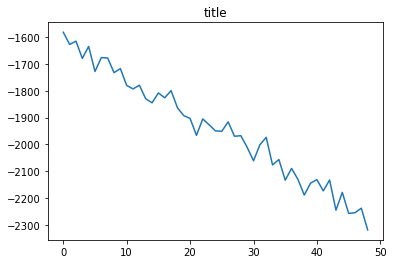

In [144]:
trainIters_NoSM(encoder56, attn_decoder56, 1, allPairs, n_epoches = 2, print_every=200, plot_every = 200, \
                criterion = nn.KLDivLoss(), learning_rate=1e-6, marker = 'KLDivLossAnotherDecIn')

In [145]:
torch.save(encoder56.state_dict(), resSeq2Seq + "//encoder_test1121_"+str(hidden_size)+"_"+str(n_layers)+'NoSM_another2'+".pth")
torch.save(attn_decoder56.state_dict(), resSeq2Seq + "//attn_decoder_test1121_"+str(hidden_size)+"_"+str(n_layers)+'NoSM_another2'+".pth")

In [147]:
preds4 = [0]*3
tgts4 = [0]*3
listChild = [9, 16, 512]
for j, i in enumerate(listChild):
    preds4[j], tgts4[j], loss = predictor(predPairs[i][0], predPairs[i][1], encoder56, attn_decoder56, nn.KLDivLoss())

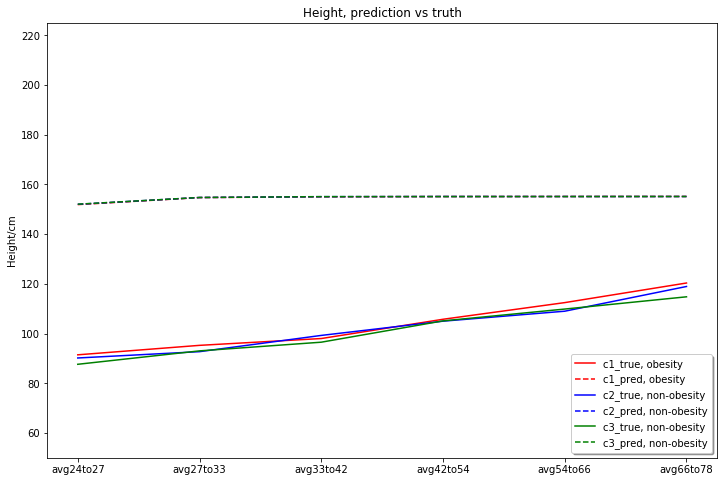

In [149]:
plotter(tgts4[0], preds4[0], tgts4[1], preds4[1], tgts4[2], preds4[2], 7, 'Height, prediction vs truth', 'Height/cm', [50, 225])

In [ ]:
plotter(tgts[0], preds[0], tgts[1], preds[1], tgts[2], preds[2], 7, 'Height, prediction vs truth', 'Height/cm', [0, 120])